In [1]:
"""
1. Make a simple bigram model
2. Do a mlp model
2. Do a wavenet model
3. Do a GPT model
"""
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from dataclasses import dataclass
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
@dataclass
class Config:
    batch_size: int

@torch.no_grad
@torch.inference_mode
def eval():
    losses = []
    for X, Y in iter(dl_val):
        y_logit, loss = model(X, Y)
        losses.append(loss.item())
    return torch.mean(torch.tensor(losses)).item()

batch_size=32
block_size=8

In [3]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [4]:
from gpt.bigram import BiGram, MLP
from gpt.data import TextDataset
torch.optim.lr_scheduler.StepLR

ds_train = TextDataset('names.txt','train', block_size=block_size)
ds_val = TextDataset('names.txt','val', block_size=block_size)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
vocab_size = len(ds_train.vocab)

In [37]:
device = torch.device("cpu")
# model = BiGram(vocab_size)
model = MLP(vocab_size)
model = model.to(device)
if hasattr(model,'seq'):
    with torch.no_grad():
      model.seq[-1].weight *= 0.1 # last layer make less confident

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)
train_losses = []
val_losses = {}

0.001

In [38]:
# n_steps = 100000
max_epochs = 20
eval_freq = 1000
step = 0
done = False
for epoch in range(1, max_epochs+1):
    for i, (X,Y) in enumerate(iter(dl_train), start=1):
        step += 1
        # break
        X = X.to(device)
        Y = Y.to(device)
        y_logit, loss = model(X, Y)
        # break
        
        optimizer.zero_grad(True)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if step % eval_freq == 0:
            val_loss = eval()
            val_losses[step] = val_loss
            lr = optimizer.param_groups[0]['lr']
            print(f'{epoch}:{i}|s={step} loss: {loss.item()} val_loss: {val_loss} lr: {lr}')
            
        train_losses.append(float(loss))
                
    print('epoch done')


1:1000|s=1000 loss: 2.5522735118865967 val_loss: 2.6233303546905518 lr: 1.0000000000000007e-13
1:2000|s=2000 loss: 2.4919092655181885 val_loss: 2.623365879058838 lr: 1.0000000000000013e-23


KeyboardInterrupt: 

In [26]:
model

MLP(
  (seq): Sequential(
    (0): Embedding(27, 128)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Permute()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Permute()
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Permute()
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Permute()
    (10): Tanh()
    (11): Linear(in_features=128, out_features=27, bias=True)
  )
)

In [27]:
# list(model.parameters())[0].var(0)

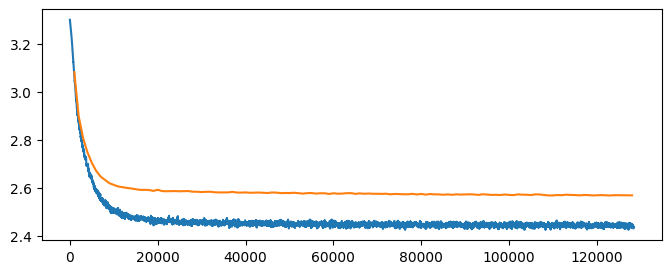

In [28]:
from scipy.signal import savgol_filter
train_losses_smoothed = savgol_filter(train_losses, 100, 1)
fig, ax = plt.subplots(1,1,figsize=(8,3))
i = list(range(0, len(train_losses), eval_freq))
ax.plot(train_losses_smoothed)
ax.plot(val_losses.keys(),val_losses.values())

In [12]:
ds_val[0]

(tensor([14, 21,  5, 12,  0,  1, 14, 19]),
 tensor([21,  5, 12,  0,  1, 14, 19, 21]))

In [13]:
x = ds_val[0][0].unsqueeze(0)
y_pred = model.predict(X, 1000)
print(''.join(ds_train.decode(y_pred[0])))

yal
aroamaqusicanynande
gevwayar
fil
a
han
pobruemna
geiyn
elynan
s
ela
ceriekanyarllel
brrolasvaniaha
myakahoratazwenonth
r
ariedenetahoreh
n
aiogramayn
x
aytaniayahangon
epah
gran
deay
lerusan
maerailalon
ayabrus
ylle
sly
aly
arsatssetoha
sanaifambade
maduoy
cema
zuk
bignde
son
b
rro
kovigian
wh
juryn
eam
co
aman
ckestth
beren
zianoamicaumiitlerlyn
gi
belajole
bana
aqueilya
t
briyn
n
etha
stzeren
alariseaylas
le
ierierlaavelen
peat
enshai
kian
beryn
ereyshttittrie
phe
ricke
lar
cer
ajon
distalelelumaramcabra
llonca
janynigi
ara
fareginala
toesarthan
ta
kyeaainn
ylimi
mow
d
cor
malismiaman
kularon
lcavi
anemalynckenazetilysite
conesh
elia
llli
a
lllor
ceyr
figisen
mayr
kicen
ze
sen
kide
dielisiealyaz
vieleaynerarinaai
tabinenas
benyarinaya
saral
zan
ara
n
linahan
aroria
ctophe
a
a
myeligrama
sa
s
zan
lele
s
zilannnamalme
lisa
ma
s
rin
mi
domdllelfet
julay
kisoieyahn
prika
chveranyma
hi
ce
pan
b
cqucoroniahnahyllideiyiscad
anann
kayaegwayliyna
toniyoin
syaronn
w
manemamacovi
calyie
lar

In [121]:
X.shape

torch.Size([9, 8])

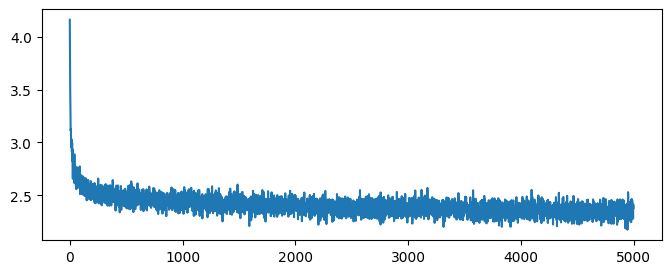

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(torch.as_tensor(losses).view(-1, 20).mean(1))

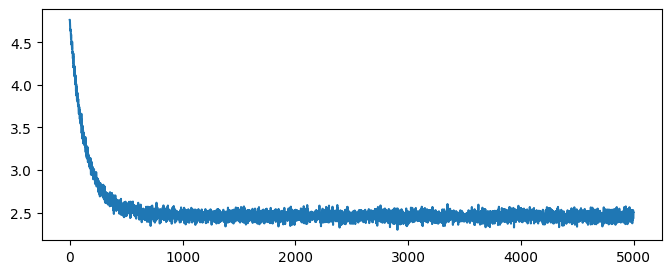

In [235]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(torch.as_tensor(losses).view(-1, 20).mean(1))

In [239]:
''.join(ds_train.decode(model.predict(X, 1000)[0]))

"rifave tentha n is il tinoue, l ie s tot SAnt fos oowi'ste n cilld harr tet; be s h grors ake, he kik\nF f foxthe iverrfeoran ce fisin suean;\nhe: w honous, gen har warry s, t horol mbleliglllly s mes PONoseaingn, matherds\nAUThaved RIO,\nAs!\nThour.\nHUCis;\nThie INGo;\nBE: foladopefit, pit se adve, h hatriernoay lecet asby wbe ff;\nA G tajou l\n\n\nRO:\nI l ags fandet VIShill.\nMathalemu\nOLAREWre ld MPred se mousoteall, mst, te d s I ts fl hat;\nCAnd tousenconowakesim,\nThur ve rorecthithase; gug mpplyo arean GBunok I MPRDWeag s haughe LI d thar,\n\nTUSetar want-t it t INThesetre wne tove ave hatt as y e y, d lpa brimugnd prd\nANThous mevol m ondeenermaverthimo tanin-m h mefry sot y und, our tar ck Hounghathe wirismyo wacevart.\nS:\nTourdertly t---dooandiromo 'sashashyor te pel mar, de't;\nGAPr d:\nR:\n\nMENoun tr-\n\nCEDWhin soucovene mumetolotours ge; be ve tootulyl oo'meantuaize sst en! IStoun, anis fund! he Wrd, binglt theel nt hiovave d ar, himas my, thashes.\nTwht! s.\nKIINCK

In [40]:
y_logit.shape

torch.Size([1, 8, 65])